# ablation study
How accurate can we make a recurring timer in a linux server?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import pandas as pd


In [2]:
# compile userspace timer test
!cargo build --release

    Finished ]8;;https://doc.rust-lang.org/cargo/reference/profiles.html#default-profiles\`release` profile [optimized + debuginfo]]8;;\ target(s) in 0.04s


In [3]:
# stress test cpus
# run on system directly
#!stress-ng -l 50 -c 1 --cpu-method rand

In [ ]:
def unit_to_ns(unit):
    unit_type = unit[-2:]
    val = float(unit[:-2])
    if unit_type == "µs" or unit_type == "us":
        return val *1000        
    if unit_type == "ms":
        return val * 1000000
    if unit_type == "ns":
        return val

def parse_result(result):
    stdout_lines = result.stdout.splitlines()
    stderr_lines = result.stderr.splitlines()
    stderr_lines = [l.strip() for l in stderr_lines]
    data = {}
    data["avg"] = stdout_lines[1].split(": ")[1]
    data["std"] = stdout_lines[2].split(": ")[1]
    data["max"] = stdout_lines[3].split(": ")[1]
    data["min"] = stdout_lines[4].split(": ")[1]
    data["jit"] = stdout_lines[5].split(": ")[1]

    data_ns = {k: unit_to_ns(v) for k,v in data.items()}
    data["cpu_cycles"] = data_ns["cpu_cycles"] = stderr_lines[7].split(" ")[0]
    
    return data, data_ns
    
program = "target/release/bpsleep"
# intervals = [10, 15, 100, 150, 1000, 1500, 10000, 
                 # 15000,30000,50000, 70000, 80000, 90000, 100000,
                 # 150000, 1000000, 1500000, 10000000, 15000000]
intervals = [10, 100, 1000, 10000, 100000, 10000000]
# intervals = [10, 100, 1000, 10000, 100000, 1000000, 10000000]

# sleep to busypoll ratios: 0 -> only busy-poll, 1 -> only sleep
ratios = [0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
attempts = 10000
interval_to_err_to_threshold = {}

timer_accuracy_ns = {}

for interval in intervals:
    interval_results_pretty = []
    interval_results_ns = []
    for r in ratios:
        # perf stat -- target/release/performance -s 10000 -a 100000 -r 0
        result = subprocess.run(["perf", "stat", "--", program, "-r", f"{r}" , "-s", f"{interval}", "-a", f"{attempts}"], capture_output=True, text=True)
        out,out_ns = parse_result(result)
        interval_results_pretty.append(out)
        interval_results_ns.append(out_ns)

    # print(data)
    print(f"The results for an interval of {interval_to_unit(interval)} are: ")
    # thresholds = [interval_to_unit(interval * ratio) for ratio in ratios]
    print(pd.DataFrame(interval_results_pretty, index=ratios))

    # update global test dictionary
    # print(interval_results_ns)
    timer_accuracy_ns[interval] = pd.DataFrame(interval_results_ns, index=ratios)
    # interval_to_err_to_threshold[interval] = tmp.to_dict()
    # print(dataframe.to_latex())
    # print("\\\\")
# print(interval_to_err_to_threshold)



The results for an interval of 10 ns are: 
            avg      std        max      min        jit cpu_cycles
0.000      75ns     40ns    3.881µs     73ns    3.808us  7,781,233
0.001  54.436µs  7.649µs  171.653µs  4.277µs  167.376us  7,093,759
0.010  54.299µs  7.808µs  188.333µs  1.716µs  186.617us  7,093,668
0.100  53.882µs  7.839µs  197.046µs  2.499µs  194.547us  7,093,718
0.200  53.544µs  7.782µs  157.377µs  5.595µs  151.782us  7,092,976
0.300  54.724µs  7.009µs  174.736µs  1.554µs  173.182us  7,092,759
0.400  54.505µs  7.692µs  169.462µs  4.225µs  165.237us  7,093,300
0.500  53.268µs  8.101µs  180.822µs  2.111µs  178.711us  7,093,270
0.600   53.99µs  7.601µs  170.463µs  2.494µs  167.969us  7,093,507
0.700  54.036µs   12.2µs  936.182µs  2.305µs  933.877us  7,093,139
0.800  53.314µs   8.27µs  156.951µs  2.775µs  154.176us  7,093,479
0.900  53.442µs  8.336µs  187.008µs   1.42µs  185.588us  7,092,888
1.000  53.092µs  8.255µs  169.049µs      2µs  167.049us  7,093,132
The results for an 

In [22]:
print(timer_accuracy_ns[10])

           avg     std       max     min       jit cpu_cycles
0.000     74.0     4.0     204.0    73.0     131.0  1,109,872
0.001  55143.0  7121.0  157830.0  3839.0  153991.0  1,043,841
0.010  55305.0  6488.0   96291.0  7691.0   88600.0  1,043,659
0.100  53413.0  7878.0   93499.0  6633.0   86866.0  1,043,393
0.200  54246.0  8198.0  140881.0  2786.0  138095.0  1,043,138
0.300  53299.0  8321.0  107466.0  6662.0  100804.0  1,043,296
0.400  53393.0  7448.0   85271.0  6760.0   78511.0  1,043,329
0.500  53091.0  8961.0  144684.0  3209.0  141475.0  1,043,370
0.600  53009.0  8444.0   91283.0  6703.0   84580.0  1,043,476
0.700  54103.0  7799.0  155042.0  8496.0  146546.0  1,043,540
0.800  54921.0  7015.0  164251.0  8420.0  155831.0  1,043,310
0.900  54419.0  7613.0  160455.0  3786.0  156669.0  1,043,763
1.000  54411.0  6269.0   85796.0  6919.0   78877.0  1,043,715


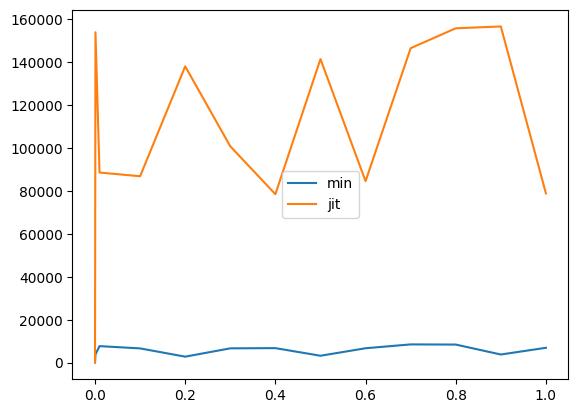

In [28]:
# fig, ax = plt.subplots()

timer_accuracy_ns[10][["min","jit"]].plot()
plt.show()